In [1]:
!pip install spikingjelly
!pip install kagglehub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 437.6/437.6 kB 7.2 MB/s eta 0:00:00


In [24]:
import torch
from spikingjelly.clock_driven import neuron
from spikingjelly import visualizing
from spikingjelly.activation_based import ann2snn
from matplotlib import pyplot as plt
import numpy as np
from torch import nn
from torch.utils.data import DataLoader
import kagglehub
from torchvision import datasets, transforms
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data import random_split
%matplotlib inline

In [25]:
# ===========================================================================
# Run some setup code for this notebook. Don't modify anything in this cell.
# ===========================================================================

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import random

RANDOM_SEED = 42
torch.manual_seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

# ===========================================================================
# A quick note on CUDA functionality (and `.to(model.device)`):
# CUDA is a parallel GPU platform produced by NVIDIA and is used by most GPU
# libraries in PyTorch. CUDA organizes GPUs into device IDs (i.e., "cuda:X" for GPU #X).
# "device" will tell PyTorch which GPU (or CPU) to place an object in. Since
# collab only uses one GPU, we will use 'cuda' as the device if a GPU is available
# and the CPU if not. You will run into problems if your tensors are on different devices.
# ===========================================================================
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [26]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Wed Oct 16 19:25:57 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P0              30W /  70W |    221MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [31]:
def accuracy(outputs,labels):
    _,preds = torch.max(outputs,dim = 1) ## _ here max prob will come and we don't require it now
    return torch.tensor(torch.sum(preds == labels).item()/len(preds))

In [64]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ANN(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(1, 32, 3, 1),
            nn.BatchNorm2d(32, eps=1e-3),
            nn.ReLU(),
            nn.AvgPool2d(2, 2),

            nn.Conv2d(32, 32, 3, 1),
            nn.BatchNorm2d(32, eps=1e-3),
            nn.ReLU(),
            nn.AvgPool2d(2, 2),

            nn.Conv2d(32, 32, 3, 1),
            nn.BatchNorm2d(32, eps=1e-3),
            nn.ReLU(),
            nn.AvgPool2d(2, 2),

            nn.Flatten(),
            nn.Linear(32, 10),
            nn.ReLU()
        )

    def forward(self, x):
        return self.network(x)


def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

def training_step(model, batch):
    images, labels = batch
    images, labels = images.to(device), labels.to(device)
    out = model(images)
    loss = F.cross_entropy(out, labels)
    return loss

# Validation step function
def validation_step(model, batch):
    images, labels = batch
    images, labels = images.to(device), labels.to(device)
    out = model(images)
    loss = F.cross_entropy(out, labels)
    acc = accuracy(out, labels)
    return {'val_loss': loss, 'val_acc': acc}



def validation_epoch_end(outputs):
    batch_losses = [x['val_loss'] for x in outputs]
    epoch_loss = torch.stack(batch_losses).mean()
    batch_acc = [x['val_acc'] for x in outputs]
    epoch_acc = torch.stack(batch_acc).mean()
    return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

def epoch_end(epoch, result):
    print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch+1, result['val_loss'], result['val_acc']))



In [65]:

torch.random.manual_seed(0)
torch.cuda.manual_seed(0)
device = 'cuda'
batch_size = 100
T = 50
num_epochs = 10



In [66]:
dataset = MNIST(root = 'data/',train=True,transform=ToTensor())

In [67]:
val_size = 10000
train_size = len(dataset) - val_size
train_ds,val_ds = random_split(dataset,[train_size,val_size])
len(train_ds), len(val_ds)

(50000, 10000)

In [68]:
batch_size = 128
train_loder = DataLoader(train_ds,batch_size,shuffle=True,num_workers=4,pin_memory=True)
val_loader = DataLoader(val_ds,batch_size,shuffle=True,num_workers=4,pin_memory=True)

Images Shape: torch.Size([128, 1, 28, 28])


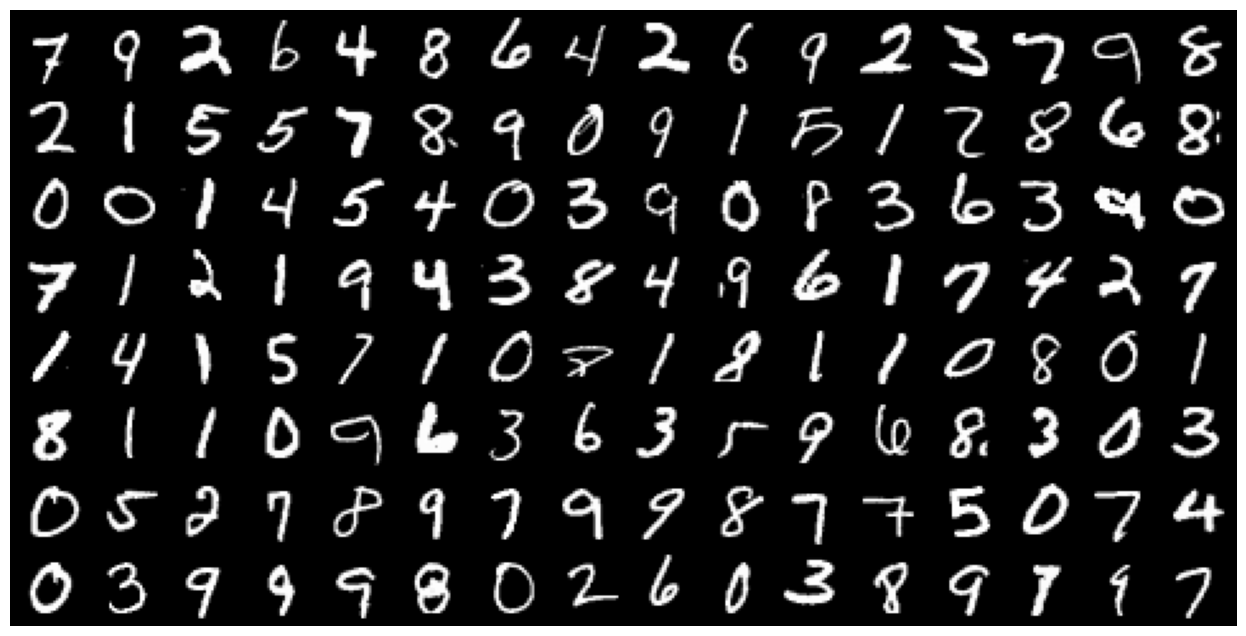

In [69]:
for images,_ in train_loder:
    print('Images Shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images,nrow=16).permute((1,2,0)))
    break

In [70]:
def evaluate(model, val_loader):
    model.eval()
    outputs = [validation_step(model, batch) for batch in val_loader]
    return validation_epoch_end(outputs)



In [71]:
# Training loop
def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)

    for epoch in range(epochs):
        model.train()
        for batch in train_loader:
            loss = training_step(model, batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        result = evaluate(model, val_loader)
        epoch_end(epoch, result)
        history.append(result)

    return history

In [72]:
model = ANN().to(device)
evaluate(model, val_loader)

{'val_loss': 2.3040130138397217, 'val_acc': 0.08326740562915802}

In [73]:
history = fit(10, 0.5, model, train_loder, val_loader)

Epoch [1], val_loss: 0.0820, val_acc: 0.9737
Epoch [2], val_loss: 0.0628, val_acc: 0.9808
Epoch [3], val_loss: 0.0638, val_acc: 0.9794
Epoch [4], val_loss: 0.0457, val_acc: 0.9855
Epoch [5], val_loss: 0.0484, val_acc: 0.9857
Epoch [6], val_loss: 0.0597, val_acc: 0.9819
Epoch [7], val_loss: 0.0415, val_acc: 0.9876
Epoch [8], val_loss: 0.0502, val_acc: 0.9857
Epoch [9], val_loss: 0.0587, val_acc: 0.9820
Epoch [10], val_loss: 0.0826, val_acc: 0.9762


In [74]:
model_converter = ann2snn.Converter(mode='max', dataloader=train_loder)
snn_model = model_converter(model)

100%|██████████| 391/391 [00:06<00:00, 64.76it/s]


In [75]:
print(snn_model)

ANN(
  (network): Module(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (3): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (7): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (8): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (11): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (12): Flatten(start_dim=1, end_dim=-1)
    (13): Linear(in_features=32, out_features=10, bias=True)
  )
  (snn tailor): Module(
    (0): Module(
      (0): VoltageScaler(0.135792)
      (1): IFNode(
        v_threshold=1.0, v_reset=None, detach_reset=False, step_mode=s, backend=torch
        (surrogate_function): Sigmoid(alpha=4.0, spiking=True)
      )
      (2): VoltageScaler(7.364214)
    )
    (1): Module(
      (0): VoltageScaler(0.187465)
      (1): IFNode(
        v_threshold=1.0, v_reset=None, detach_reset=False, step_mode=s, backend=torch
        (surrogate_function): Sigmoid(alpha=4.0, spiking=True)
      )
   

In [76]:
from torch.fx import GraphModule

snn_model.graph.print_tabular()

opcode       name            target          args               kwargs
-----------  --------------  --------------  -----------------  --------
placeholder  x               x               ()                 {}
call_module  network_0       network.0       (x,)               {}
call_module  snn_tailor_0_1  snn tailor.0.0  (network_0,)       {}
call_module  snn_tailor_0_2  snn tailor.0.1  (snn_tailor_0_1,)  {}
call_module  snn_tailor_0_3  snn tailor.0.2  (snn_tailor_0_2,)  {}
call_module  network_3       network.3       (snn_tailor_0_3,)  {}
call_module  network_4       network.4       (network_3,)       {}
call_module  snn_tailor_1_1  snn tailor.1.0  (network_4,)       {}
call_module  snn_tailor_1_2  snn tailor.1.1  (snn_tailor_1_1,)  {}
call_module  snn_tailor_1_3  snn tailor.1.2  (snn_tailor_1_2,)  {}
call_module  network_7       network.7       (snn_tailor_1_3,)  {}
call_module  network_8       network.8       (network_7,)       {}
call_module  snn_tailor_2_1  snn tailor.2.0  (networ

In [85]:
def val(snn_model, device, val_loader, T=50):
    """Evaluate SNN model and return maximum accuracy across time steps."""
    snn_model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in val_loader:
            images, labels = batch
            images, labels = images.to(device), labels.to(device)

            s_list = []
            for t in range(T):
                outputs = snn_model(images)
                s_list.append(outputs)


            s_list = [s for s in s_list if s.size(0) == images.size(0)]

            spikes = torch.stack(s_list).mean(dim=0)


            _, predicted = torch.max(spikes, dim=1)


            correct += (predicted == labels).sum().item()
            total += labels.size(0)


    accuracy = 100 * correct / total
    return accuracy


In [86]:
print('---------------------------------------------')
print('Converting using MaxNorm')
model_converter = ann2snn.Converter(mode='max', dataloader=train_loder)
snn_model = model_converter(model)
print('Simulating...')
mode_max_accs = val(snn_model, device, val_loader, T=T)
print('SNN accuracy (simulation %d time-steps): %.4f' % (T, mode_max_accs[-1]))

print('---------------------------------------------')
print('Converting using RobustNorm')
model_converter = ann2snn.Converter(mode='99.9%', dataloader=train_loder)
snn_model = model_converter(model)
print('Simulating...')
mode_robust_accs = val(snn_model, device, val_loader, T=T)
print('SNN accuracy (simulation %d time-steps): %.4f' % (T, mode_robust_accs[-1]))

print('---------------------------------------------')
print('Converting using 1/2 max(activation) as scales...')
model_converter = ann2snn.Converter(mode=1.0 / 2, dataloader=train_loder)
snn_model = model_converter(model)
print('Simulating...')
mode_two_accs = val(snn_model, device, val_loader, T=T)
print('SNN accuracy (simulation %d time-steps): %.4f' % (T, mode_two_accs[-1]))

print('---------------------------------------------')
print('Converting using 1/3 max(activation) as scales')
model_converter = ann2snn.Converter(mode=1.0 / 3, dataloader=train_loder)
snn_model = model_converter(model)
print('Simulating...')
mode_three_accs = val(snn_model, device, val_loader, T=T)
print('SNN accuracy (simulation %d time-steps): %.4f' % (T, mode_three_accs[-1]))

print('---------------------------------------------')
print('Converting using 1/4 max(activation) as scales')
model_converter = ann2snn.Converter(mode=1.0 / 4, dataloader=train_loder)
snn_model = model_converter(model)
print('Simulating...')
mode_four_accs = val(snn_model, device, val_loader, T=T)
print('SNN accuracy (simulation %d time-steps): %.4f' % (T, mode_four_accs[-1]))

print('---------------------------------------------')
print('Converting using 1/5 max(activation) as scales')
model_converter = ann2snn.Converter(mode=1.0 / 5, dataloader=train_loder)
snn_model = model_converter(model)
print('Simulating...')
mode_five_accs = val(snn_model, device, val_loader, T=T)
print('SNN accuracy (simulation %d time-steps): %.4f' % (T, mode_five_accs[-1]))

---------------------------------------------
Converting using MaxNorm


100%|██████████| 391/391 [00:08<00:00, 45.91it/s]

Simulating...


RuntimeError: The following operation failed in the TorchScript interpreter.
Traceback of TorchScript (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/spikingjelly/activation_based/neuron.py", line 474, in fallback_function
    @torch.jit.script
    def jit_eval_single_step_forward_soft_reset(x: torch.Tensor, v: torch.Tensor, v_threshold: float):
        v = v + x
            ~~~~~ <--- HERE
        spike = (v >= v_threshold).to(x)
        v = v - spike * v_threshold
RuntimeError: The size of tensor a (128) must match the size of tensor b (16) at non-singleton dimension 0


In [87]:
fig = plt.figure()
plt.plot(np.arange(0, T), mode_max_accs, label='mode: max')
plt.plot(np.arange(0, T), mode_robust_accs, label='mode: 99.9%')
plt.plot(np.arange(0, T), mode_two_accs, label='mode: 1.0/2')
plt.plot(np.arange(0, T), mode_three_accs, label='mode: 1.0/3')
plt.plot(np.arange(0, T), mode_four_accs, label='mode: 1.0/4')
plt.plot(np.arange(0, T), mode_five_accs, label='mode: 1.0/5')
plt.legend()
plt.xlabel('t')
plt.ylabel('Acc')
plt.show()

NameError: name 'mode_max_accs' is not defined

<Figure size 640x480 with 0 Axes>